In [1]:
import subprocess
import sys
result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
print(result.stdout if result.returncode == 0 else 'GPU not available')

Sat Sep 27 23:25:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.06             Driver Version: 550.144.06     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10-24Q                 On  |   00000002:00:00.0 Off |                    0 |
| N/A   N/A    P0             N/A /  N/A  |     182MiB /  24512MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import subprocess
import sys
import os
import shutil
from pathlib import Path

def pip_install(*args):
    print('>', *args, flush=True)
    subprocess.run([sys.executable, '-m', 'pip', *args], check=True)

# 0) Hard reset any prior torch stacks
for pkg in ('torch', 'torchvision', 'torchaudio'):
    subprocess.run([sys.executable, '-m', 'pip', 'uninstall', '-y', pkg], check=False)

# Clean stray site dirs
for d in (
    '/app/.pip-target/torch',
    '/app/.pip-target/torch-2.8.0.dist-info',
    '/app/.pip-target/torch-2.4.1.dist-info',
    '/app/.pip-target/torchvision',
    '/app/.pip-target/torchvision-0.23.0.dist-info',
    '/app/.pip-target/torchvision-0.19.1.dist-info',
    '/app/.pip-target/torchaudio',
    '/app/.pip-target/torchaudio-2.8.0.dist-info',
    '/app/.pip-target/torchaudio-2.4.1.dist-info',
    '/app/.pip-target/torchgen',
    '/app/.pip-target/functorch'
):
    if os.path.exists(d):
        print('Removing', d)
        shutil.rmtree(d, ignore_errors=True)

# 1) Install the EXACT cu121 torch stack FIRST
pip_install('install',
    '--index-url', 'https://download.pytorch.org/whl/cu121',
    '--extra-index-url', 'https://pypi.org/simple',
    'torch==2.4.1', 'torchvision==0.19.1', 'torchaudio==2.4.1')

# 2) Create a constraints file
Path('constraints.txt').write_text(
    'torch==2.4.1\n'
    'torchvision==0.19.1\n'
    'torchaudio==2.4.1\n'
)

# 3) Install NON-torch deps
pip_install('install', '-c', 'constraints.txt',
    'transformers==4.44.2', 'accelerate==0.34.2',
    'datasets==2.21.0', 'evaluate==0.4.2',
    'sentencepiece', 'scikit-learn',
    '--upgrade-strategy', 'only-if-needed')

# 4) Sanity check
import torch
print('torch:', torch.__version__, 'built CUDA:', getattr(torch.version, 'cuda', None))
print('CUDA available:', torch.cuda.is_available())
assert str(getattr(torch.version, 'cuda', '')).startswith('12.1'), f'Wrong CUDA build: {torch.version.cuda}'
assert torch.cuda.is_available(), 'CUDA not available'
print('GPU:', torch.cuda.get_device_name(0))

> install --index-url https://download.pytorch.org/whl/cu121 --extra-index-url https://pypi.org/simple torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1


Looking in indexes: https://download.pytorch.org/whl/cu121, https://pypi.org/simple


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 MB 257.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 86.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 146.5 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 187.5 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 KB 493.5 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 158.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 299.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 KB 388.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 223.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 247.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 KB 459.0 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 199.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 289.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 KB 458.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 KB 512.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 181.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 250.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 429.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 217.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 324.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 237.0 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 194.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 KB 502.8 MB/s eta 0:00:00


In [4]:
# Explore dataset structure
import json
import pandas as pd
from collections import Counter

# Load train metadata
with open('nybg2020/train/metadata.json', 'r') as f:
    train_data = json.load(f)

print('Train data keys:', list(train_data.keys()))
print('Number of images:', len(train_data.get('images', [])))
print('Number of annotations:', len(train_data.get('annotations', [])))
print('Number of categories:', len(train_data.get('categories', [])))

# Create DataFrames for images and annotations
train_images_df = pd.DataFrame(train_data.get('images', []))
train_annotations_df = pd.DataFrame(train_data.get('annotations', []))

print('\nTrain images DataFrame shape:', train_images_df.shape)
print('\nTrain images columns:', train_images_df.columns.tolist())
print('\nFirst few train images:')
print(train_images_df.head())

print('\nTrain annotations DataFrame shape:', train_annotations_df.shape)
print('\nTrain annotations columns:', train_annotations_df.columns.tolist())
print('\nFirst few train annotations:')
print(train_annotations_df.head())

print('\nSample category:')
print(train_data['categories'][0] if 'categories' in train_data else 'No categories')

# Load test metadata
with open('nybg2020/test/metadata.json', 'r') as f:
    test_data = json.load(f)

print('\nTest data keys:', list(test_data.keys()))
print('Number of test images:', len(test_data.get('images', [])))

test_images_df = pd.DataFrame(test_data.get('images', []))
print('\nTest images DataFrame shape:', test_images_df.shape)
print('\nTest images columns:', test_images_df.columns.tolist())
print('\nFirst few test images:')
print(test_images_df.head())

Train data keys: ['annotations', 'categories', 'images', 'info', 'licenses', 'regions']
Number of images: 811623
Number of annotations: 811623
Number of categories: 32094



Train images DataFrame shape: (811623, 5)

Train images columns: ['file_name', 'height', 'id', 'license', 'width']

First few train images:
                  file_name  height      id  license  width
0  images/156/72/124136.jpg    1000  124136        1    661
1    images/156/72/5327.jpg    1000    5327        1    661
2  images/156/72/449419.jpg    1000  449419        1    662
3   images/156/72/29079.jpg    1000   29079        1    661
4  images/156/72/368979.jpg    1000  368979        1    667

Train annotations DataFrame shape: (811623, 4)

Train annotations columns: ['category_id', 'id', 'image_id', 'region_id']

First few train annotations:
   category_id      id  image_id  region_id
0        15672  124136    124136          1
1        15672    5327      5327          1
2        15672  449419    449419          1
3        15672   29079     29079          1
4        15672  368979    368979          1

Sample category:
{'family': 'Orchidaceae', 'genus': 'Aa', 'id': 0, 'name': 'Aa ma


Test images DataFrame shape: (219124, 5)

Test images columns: ['file_name', 'height', 'id', 'license', 'width']

First few test images:
          file_name  height id  license  width
0  images/000/0.jpg    1000  0        1    667
1  images/000/1.jpg    1000  1        1    667
2  images/000/2.jpg    1000  2        1    675
3  images/000/3.jpg    1000  3        1    676
4  images/000/4.jpg    1000  4        1    678


Number of unique classes: 32093
Classes with samples: 32093
Samples per class - Min: 1
Max: 1412
Mean: 25.289720499797465
Median: 7.0

Top 10 most frequent classes:
Class 23718: 1412 samples
Class 163: 956 samples
Class 5340: 872 samples
Class 23713: 861 samples
Class 8437: 819 samples
Class 4232: 784 samples
Class 31010: 737 samples
Class 11931: 736 samples
Class 17078: 721 samples
Class 12779: 712 samples

Bottom 10 least frequent classes:
Class 26958: 1 samples
Class 8928: 1 samples
Class 26515: 1 samples
Class 25003: 1 samples
Class 13792: 1 samples
Class 25266: 1 samples
Class 9588: 1 samples
Class 28957: 1 samples
Class 28988: 1 samples
Class 5258: 1 samples

Percentage of classes with <10 samples: 58.71%

Sample categories with names:
   id                                               name       family    genus
0   0                     Aa mathewsii (Rchb.f.) Schltr.  Orchidaceae       Aa
1   1                        Aa paleacea (Kunth) Rchb.f.  Orchidaceae       Aa
2   2  Abar

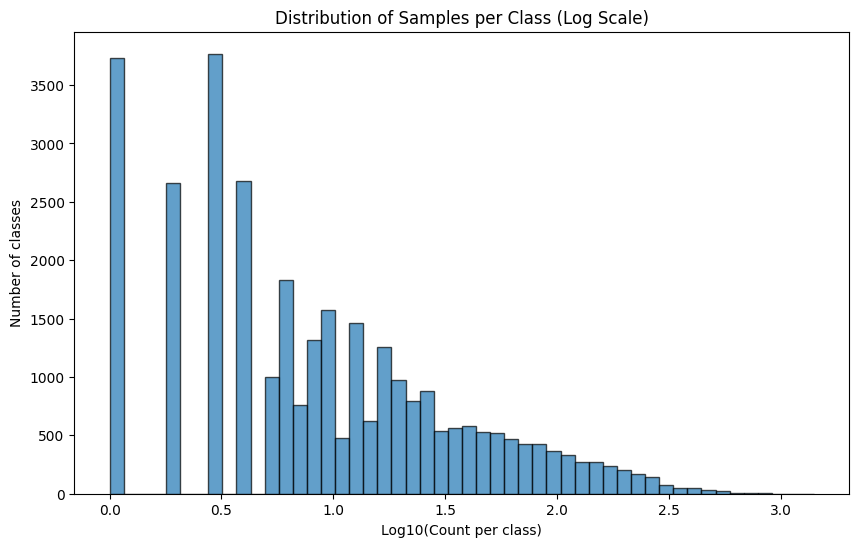

In [5]:
# Class distribution analysis
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_annotations_df is available from previous cell
class_counts = Counter(train_annotations_df['category_id'])

print('Number of unique classes:', len(class_counts))
print('Classes with samples:', len([c for c, cnt in class_counts.items() if cnt > 0]))

counts = list(class_counts.values())
print('Samples per class - Min:', min(counts))
print('Max:', max(counts))
print('Mean:', np.mean(counts))
print('Median:', np.median(counts))

print('\nTop 10 most frequent classes:')
for category_id, count in class_counts.most_common(10):
    print(f'Class {category_id}: {count} samples')

print('\nBottom 10 least frequent classes:')
for category_id, count in sorted(class_counts.items(), key=lambda x: x[1])[:10]:
    print(f'Class {category_id}: {count} samples')

# Percentage of classes with few samples
rare_classes = sum(1 for cnt in counts if cnt < 10) / len(counts) * 100
print(f'\nPercentage of classes with <10 samples: {rare_classes:.2f}%')

# Plot histogram of log(class counts)
plt.figure(figsize=(10, 6))
plt.hist(np.log10(counts), bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Log10(Count per class)')
plt.ylabel('Number of classes')
plt.title('Distribution of Samples per Class (Log Scale)')
plt.show()

# Merge with categories for names
categories_df = pd.DataFrame(train_data['categories'])
print('\nSample categories with names:')
print(categories_df[['id', 'name', 'family', 'genus']].head())

In [6]:
# Verify PyTorch installation and install additional packages
import subprocess
import sys
import importlib.util

# Check if torch is installed
if importlib.util.find_spec('torch') is None:
    print('PyTorch not installed, installing...')
    subprocess.run([sys.executable, '-m', 'pip', 'cache', 'purge'], check=False)
    subprocess.run([
        sys.executable, '-m', 'pip', 'install',
        '--index-url', 'https://download.pytorch.org/whl/cu121',
        '--extra-index-url', 'https://pypi.org/simple',
        'torch==2.4.1', 'torchvision==0.19.1', 'torchaudio==2.4.1'
    ], check=True)
else:
    print('PyTorch already installed')

# Install additional packages as per experts
subprocess.run([
    sys.executable, '-m', 'pip', 'install',
    'timm', 'albumentations', 'opencv-python-headless', 'scikit-learn'
], check=True)

# Verify torch and CUDA
import torch
print('torch version:', torch.__version__)
print('CUDA version:', torch.version.cuda)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('GPU not available - exiting competition')
    import sys; sys.exit(1)

PyTorch not installed, installing...


ERROR: pip cache commands can not function since cache is disabled.


Looking in indexes: https://download.pytorch.org/whl/cu121, https://pypi.org/simple


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 MB 304.8 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 302.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 383.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 KB 3.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 198.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 244.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 KB 471.0 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 242.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 KB 375.8 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 242.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 249.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 44.0 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 KB 438.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 KB 381.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 245.5 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 277.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 115.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 498.8 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 236.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 243.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 258.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 230.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 121.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 KB 309.8 MB/s eta 0:00:00
